# Importação de Bibliotecas

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA, TruncatedSVD
from collections import Counter
import math
from sklearn.neighbors import NearestNeighbors

# Carregamento dos dados

In [78]:
ratings = pd.read_csv(rf'ratings.dat', sep='::', header=None, engine='python', encoding= "utf-8", names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies = pd.read_csv(rf'movies.dat', sep='::', header=None, engine='python', encoding= "utf-8", names=['movie_id', 'title', 'genres'], encoding_errors='ignore')

display(ratings.info())
display(movies.info())
display(ratings.head())
display(movies.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


None

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# Visualização de Dados

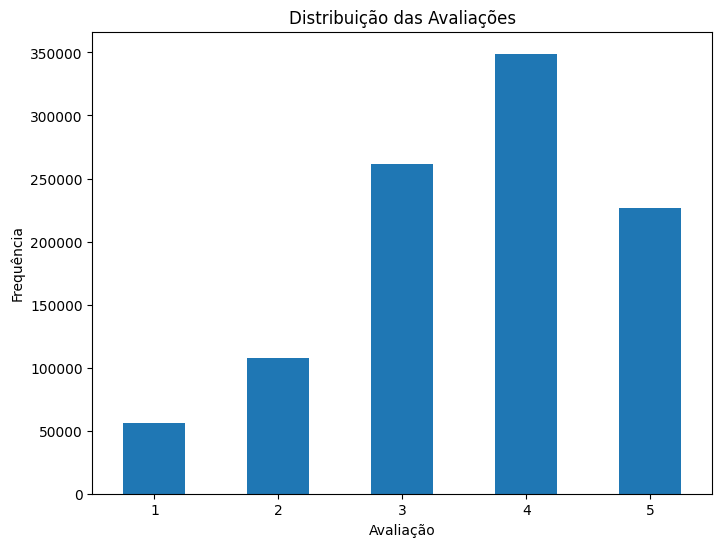

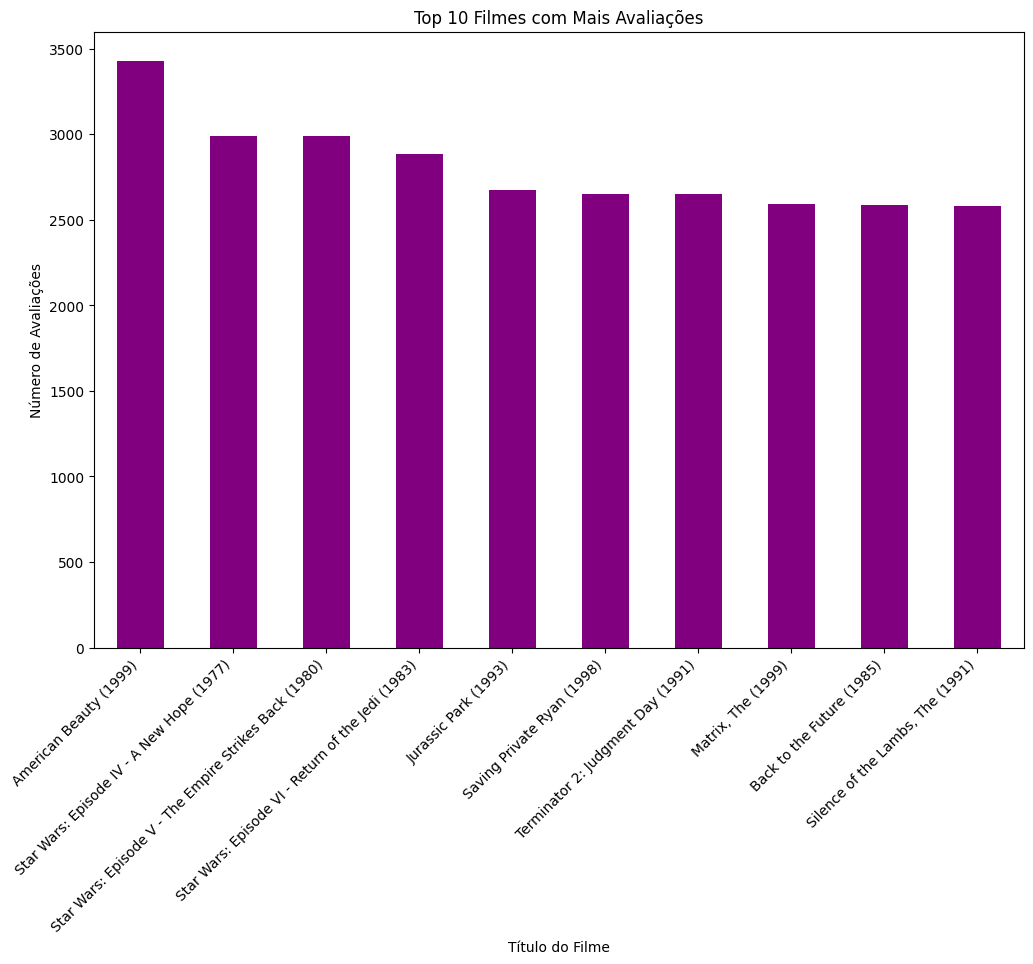

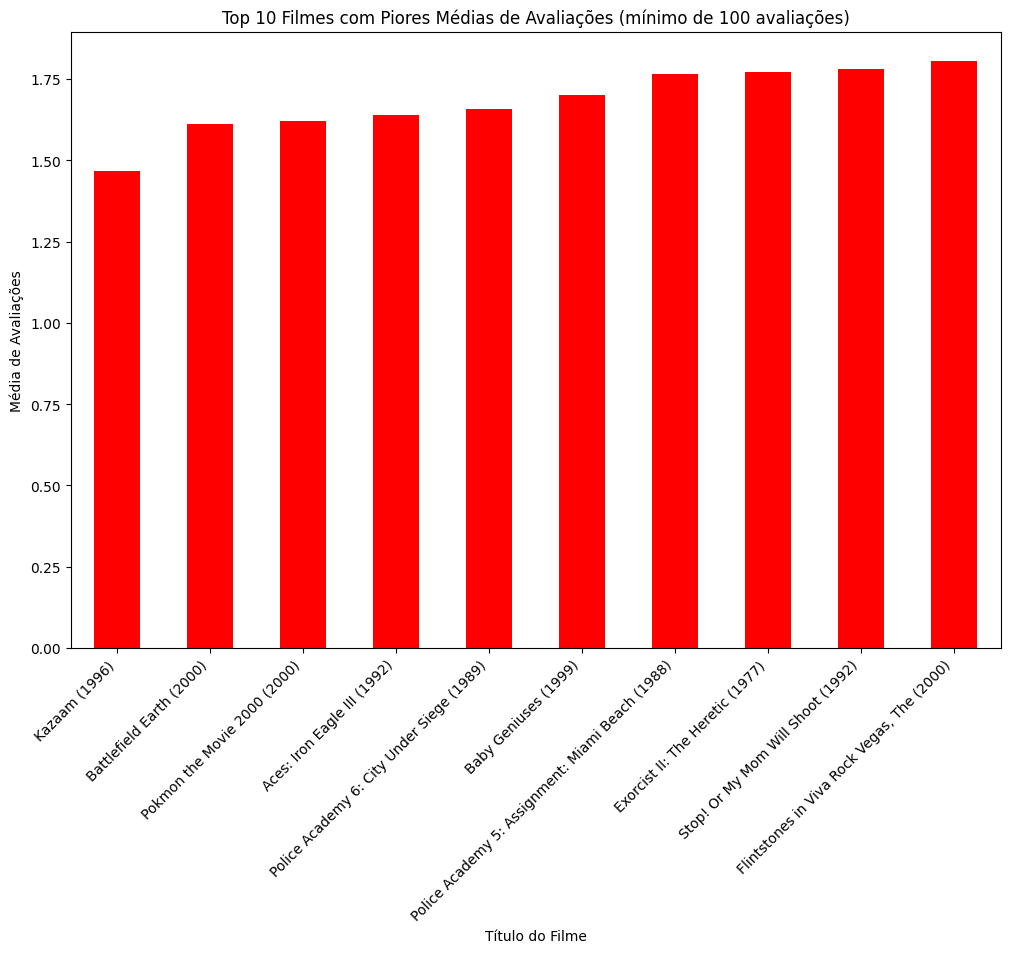

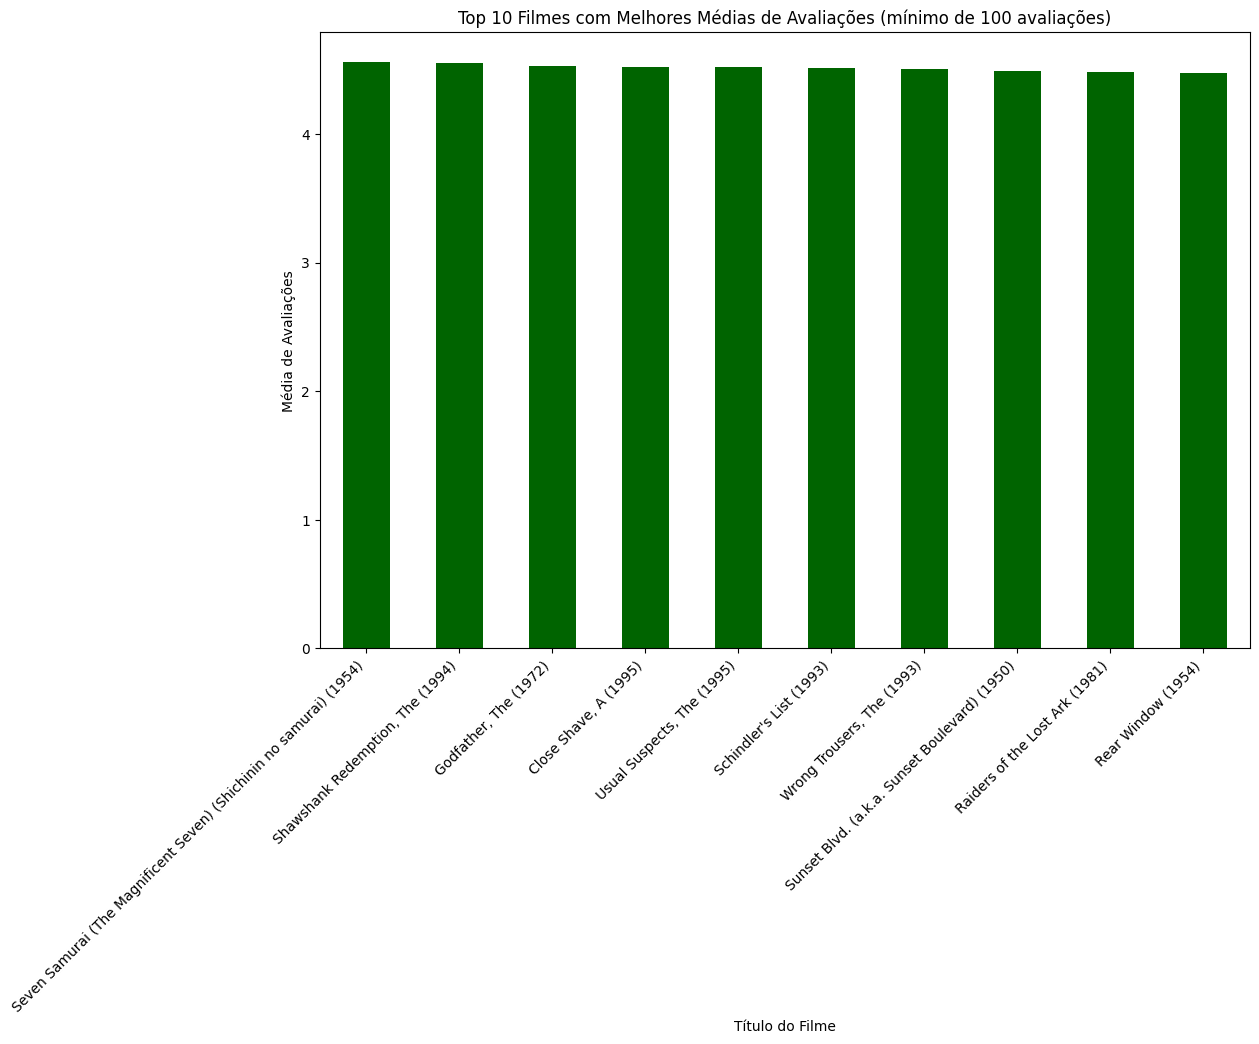

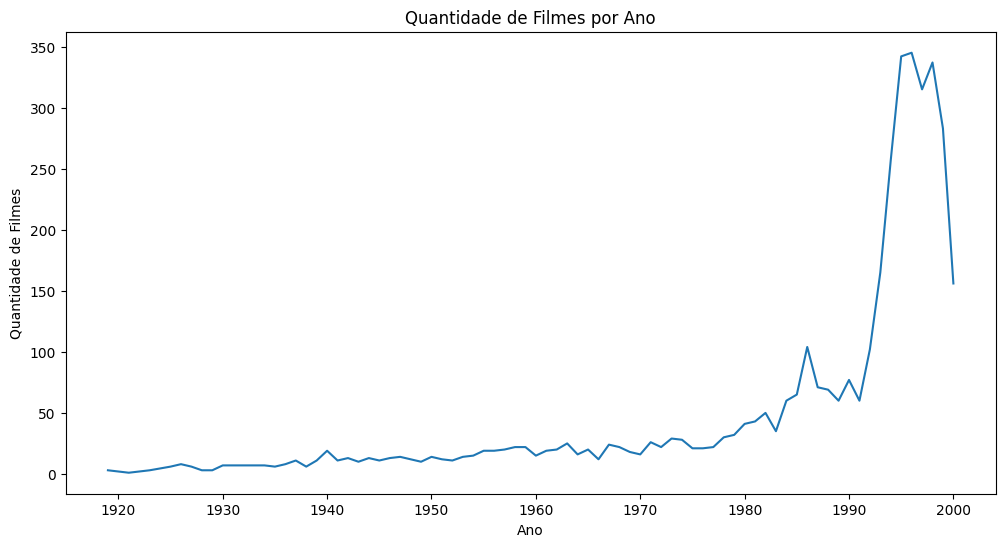

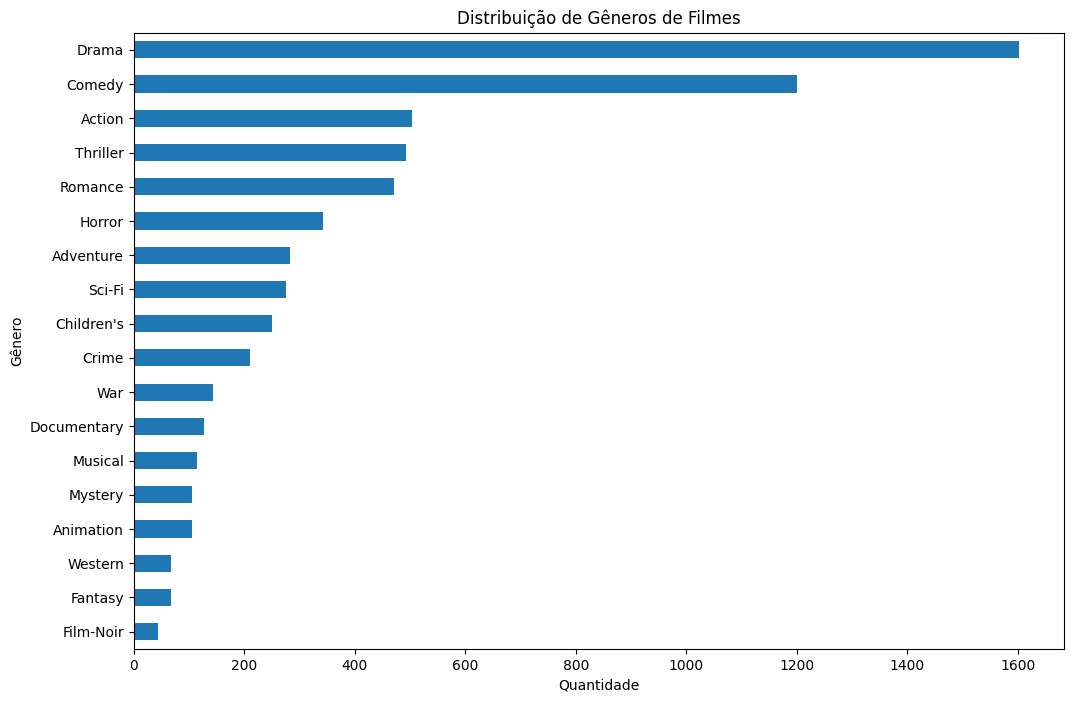

In [79]:
plt.figure(figsize=(8, 6))
ratings['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribuição das Avaliações')
plt.xlabel('Avaliação')
plt.ylabel('Frequência')
plt.xticks(rotation=0)
plt.show()


# Calculando o número de avaliações por filme
movie_rating_counts = ratings['movie_id'].value_counts().head(10)

# Juntando com os dados dos filmes para obter os títulos
top_rated_movies = movies.set_index('movie_id').loc[movie_rating_counts.index, 'title']

# Criando um gráfico de barras para os filmes mais avaliados
plt.figure(figsize=(12, 8))
movie_rating_counts.plot(kind='bar', color='purple')
plt.title('Top 10 Filmes com Mais Avaliações')
plt.xlabel('Título do Filme')
plt.ylabel('Número de Avaliações')
plt.xticks(ticks=range(10), labels=top_rated_movies, rotation=45, ha='right')
plt.show()

# Calculando a média de avaliações para cada filme com pelo menos 100 avaliações
movie_avg_ratings = ratings.groupby('movie_id').agg({'rating': ['mean', 'count']})
movie_avg_ratings.columns = ['AverageRating', 'Count']
top_average_rated_movies = movie_avg_ratings[movie_avg_ratings['Count'] >= 100].sort_values(by='AverageRating', ascending=False).head(10)

# Juntando com os dados dos filmes para obter os títulos
top_avg_rated_movie_titles = movies.set_index('movie_id').loc[top_average_rated_movies.index, 'title']

# Identificando os 10 filmes com as piores médias de avaliações, considerando filmes com pelo menos 100 avaliações
worst_average_rated_movies = movie_avg_ratings[movie_avg_ratings['Count'] >= 100].sort_values(by='AverageRating', ascending=True).head(10)

# Juntando com os dados dos filmes para obter os títulos
worst_avg_rated_movie_titles = movies.set_index('movie_id').loc[worst_average_rated_movies.index, 'title']

# Criando um gráfico de barras para os filmes com piores médias de avaliações
plt.figure(figsize=(12, 8))
worst_average_rated_movies['AverageRating'].plot(kind='bar', color='red')
plt.title('Top 10 Filmes com Piores Médias de Avaliações (mínimo de 100 avaliações)')
plt.xlabel('Título do Filme')
plt.ylabel('Média de Avaliações')
plt.xticks(ticks=range(10), labels=worst_avg_rated_movie_titles, rotation=45, ha='right')
plt.show()


# Criando um gráfico de barras para os filmes com melhores médias de avaliações
plt.figure(figsize=(12, 8))
top_average_rated_movies['AverageRating'].plot(kind='bar', color='darkgreen')
plt.title('Top 10 Filmes com Melhores Médias de Avaliações (mínimo de 100 avaliações)')
plt.xlabel('Título do Filme')
plt.ylabel('Média de Avaliações')
plt.xticks(ticks=range(10), labels=top_avg_rated_movie_titles, rotation=45, ha='right')
plt.show()

# Extrair o ano do título do filme
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

# Plotar quantidade de filmes por ano
plt.figure(figsize=(12, 6))
movies['year'].value_counts().sort_index().plot(kind='line')
plt.title('Quantidade de Filmes por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Filmes')
plt.show()


# Contagem de todos os gêneros
genre_counts = Counter(genre for genres in movies['genres'] for genre in genres.split('|'))

# Plot
plt.figure(figsize=(12, 8))
pd.Series(genre_counts).sort_values().plot(kind='barh')
plt.title('Distribuição de Gêneros de Filmes')
plt.xlabel('Quantidade')
plt.ylabel('Gênero')
plt.show()


# Preprocessamento de dados

## Verificação e Remoção de Valores Duplicados

In [80]:
# Removendo duplicatas nas avaliações
ratings_before = len(ratings)
ratings.drop_duplicates(inplace=True)
ratings_after = len(ratings)

# Removendo duplicatas nos filmes
movies_before = len(movies)
movies.drop_duplicates(subset='movie_id', keep='first', inplace=True)
movies_after = len(movies)

print(f'Duplicatas removidas de ratings: {ratings_before - ratings_after}')
print(f'Duplicatas removidas de movies: {movies_before - movies_after}')


Duplicatas removidas de ratings: 0
Duplicatas removidas de movies: 0


## Normalização dos Dados

In [81]:
# Normalização das avaliações
scaler = StandardScaler()
ratings['rating_scaled'] = scaler.fit_transform(ratings[['rating']])

# Verificar as primeiras linhas para observar o resultado da normalização
print(ratings.head())


   user_id  movie_id  rating  timestamp  rating_scaled
0        1      1193       5  978300760       1.269747
1        1       661       3  978302109      -0.520601
2        1       914       3  978301968      -0.520601
3        1      3408       4  978300275       0.374573
4        1      2355       5  978824291       1.269747


## Tratamento de Dados Faltantes

In [82]:
# Verificação de dados faltantes
print(f'Valores faltantes em ratings: \n{ratings.isnull().sum()}')
print(f'Valores faltantes em movies: \n{movies.isnull().sum()}')

# Decisão sobre o tratamento de dados faltantes (se necessário)
# Exemplo: remover linhas com valores faltantes em 'year' em movies
movies.dropna(subset=['year'], inplace=True)


Valores faltantes em ratings: 
user_id          0
movie_id         0
rating           0
timestamp        0
rating_scaled    0
dtype: int64
Valores faltantes em movies: 
movie_id    0
title       0
genres      0
year        0
dtype: int64


## Preparação Final

In [83]:
# Resumo final dos dados
print(f'Tamanho final dos dados de ratings: {ratings.shape}')
print(f'Tamanho final dos dados de movies: {movies.shape}')


Tamanho final dos dados de ratings: (1000209, 5)
Tamanho final dos dados de movies: (3883, 4)


# Cálculo das Matrizes de Distâncias e Aplicação dos Algoritmos de Clusterização

## Preparação dos Dados
Antes de aplicar qualquer algoritmo de clusterização, precisamos preparar os dados. Vamos criar uma matriz de características usando as avaliações dos usuários para cada filme. Para simplificar, consideraremos apenas uma amostra dos dados para facilitar o processamento.

In [111]:
# Criar uma tabela pivot com usuários nas linhas e filmes nas colunas
user_movie_ratings = ratings.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)
display(user_movie_ratings.head())

# Amostra dos dados para reduzir a complexidade computacional (opcional)
sample_data = user_movie_ratings

print(sample_data.shape)


movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(6040, 3706)


## K-means Clustering
Esta célula do notebook Python realiza a análise de clustering utilizando o algoritmo K-means. O processo é dividido em várias etapas:

1. **Cálculo da Inércia (WCSS)**: A função `calculate_wcss` calcula a soma dos quadrados das distâncias dentro do cluster (WCSS - Within-Cluster Sum of Square) para diferentes números de clusters (de 2 a 20). A inércia é uma medida da coesão interna dos clusters.

2. **Determinação do Número Ótimo de Clusters**: A função `optimal_number_of_clusters` utiliza o método do cotovelo para determinar o número ótimo de clusters. Este método calcula a distância de cada ponto (representando o WCSS para um determinado número de clusters) até a linha formada pelos pontos extremos (número mínimo e máximo de clusters). O ponto com a maior distância a esta linha indica o número ótimo de clusters.

3. **Visualização do Método do Cotovelo**: Utiliza a biblioteca `matplotlib` para plotar o gráfico do método do cotovelo, mostrando como a inércia varia com o número de clusters. Este gráfico ajuda a visualizar o ponto onde o aumento no número de clusters deixa de resultar em melhorias significativas na inércia, indicando o número ótimo de clusters.

4. **Aplicação do K-means com o Número Ótimo de Clusters**: Finalmente, o algoritmo K-means é aplicado usando o número ótimo de clusters determinado anteriormente. O resultado é um modelo capaz de agrupar os dados de entrada em clusters significativos.

Este processo é uma parte fundamental da análise de cluster, permitindo identificar agrupamentos naturais dentro dos dados sem a necessidade de etiquetas pré-definidas.

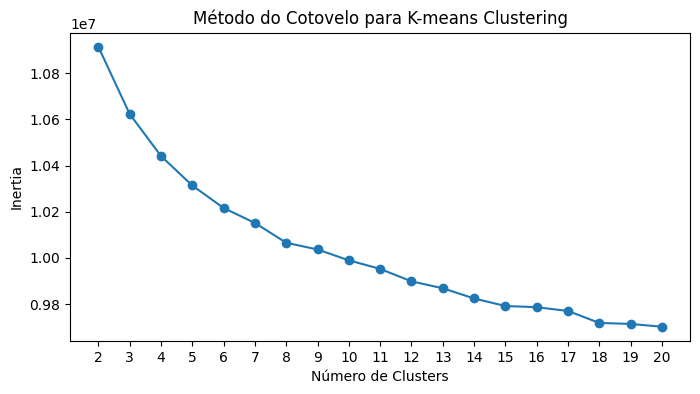

Número ótimo de clusters: 8


In [121]:
def calculate_wcss(data):
    inertia = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(X=data)
        inertia.append(kmeans.inertia_)

    return inertia

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)

    return distances.index(max(distances)) + 2

inertia = calculate_wcss(sample_data)
plt.figure(figsize=(8, 4))
plt.plot(range(2, 21), inertia, marker='o')
plt.title('Método do Cotovelo para K-means Clustering')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.xticks(range(2, 21))
plt.show()

# Aplicar K-means com um número apropriado de clusters
n = optimal_number_of_clusters(inertia)
print(f'Número ótimo de clusters: {n}')
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_clusters = kmeans.fit_predict(sample_data)



## DBSCAN
Agora, vamos usar o algoritmo DBSCAN, que é baseado em densidade e pode capturar clusters de formas variadas.

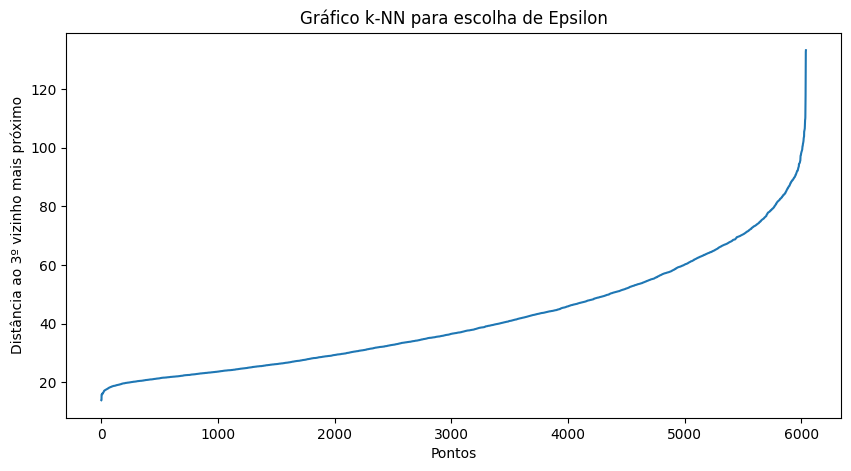

O valor sugerido para Epsilon é: 94.38749917229505
Número de outliers: 366


In [86]:
def calculate_knee_point(distances):
    # Assegura que as distâncias estão ordenadas
    distances = np.sort(distances)
    
    # Normalizando as distâncias para garantir que o cálculo da curvatura não seja afetado pela escala
    normalized_distances = (distances - min(distances)) / (max(distances) - min(distances))
    
    # Coordenadas dos pontos
    n_points = len(normalized_distances)
    all_coords = np.vstack((range(n_points), normalized_distances)).T
    
    # Linha entre o primeiro e o último ponto
    first_point = all_coords[0]
    last_point = all_coords[-1]
    line_vec = last_point - first_point
    
    # Vetor perpendicular à linha
    line_vec_norm = line_vec / np.linalg.norm(line_vec)
    vec_from_first = all_coords - first_point
    
    # Distância de cada ponto à linha (componente perpendicular)
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    
    # Distância ao quadrado da linha
    dist_to_line = np.sum(vec_to_line ** 2, axis=1)
    
    # Índice do ponto com a maior distância à linha
    index_of_best_point = np.argmax(dist_to_line)
    
    return index_of_best_point

# Exemplo de uso
# Supondo que 'data' é seu conjunto de dados
k = int(1.5*sample_data.shape[1])
neighbors = NearestNeighbors(n_neighbors=k)  # Suponha que escolhemos MinPts como 4
neighbors_fit = neighbors.fit(sample_data)
distances, indices = neighbors_fit.kneighbors(sample_data)
k_distances = distances[:, k-1]
epsilon = calculate_knee_point(k_distances)

# Ordena as distâncias
sorted_distances = np.sort(distances[:, 3], axis=0)  # A distância ao 3º vizinho mais próximo
plt.figure(figsize=(10, 5))
plt.plot(sorted_distances)
plt.title("Gráfico k-NN para escolha de Epsilon")
plt.xlabel("Pontos")
plt.ylabel("Distância ao 3º vizinho mais próximo")
plt.show()

print(f"O valor sugerido para Epsilon é: {k_distances[epsilon]}")
print(f'Número de outliers: {len(k_distances[k_distances > k_distances[epsilon]])}')


In [87]:
# Normalização dos dados
scaler = StandardScaler()
data_scaled = scaler.fit_transform(sample_data)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=k)
dbscan_clusters = dbscan.fit_predict(data_scaled)


## Clustering Hierárquico
Por fim, aplicaremos o clustering hierárquico para visualizar os clusters em diferentes níveis de agregação.

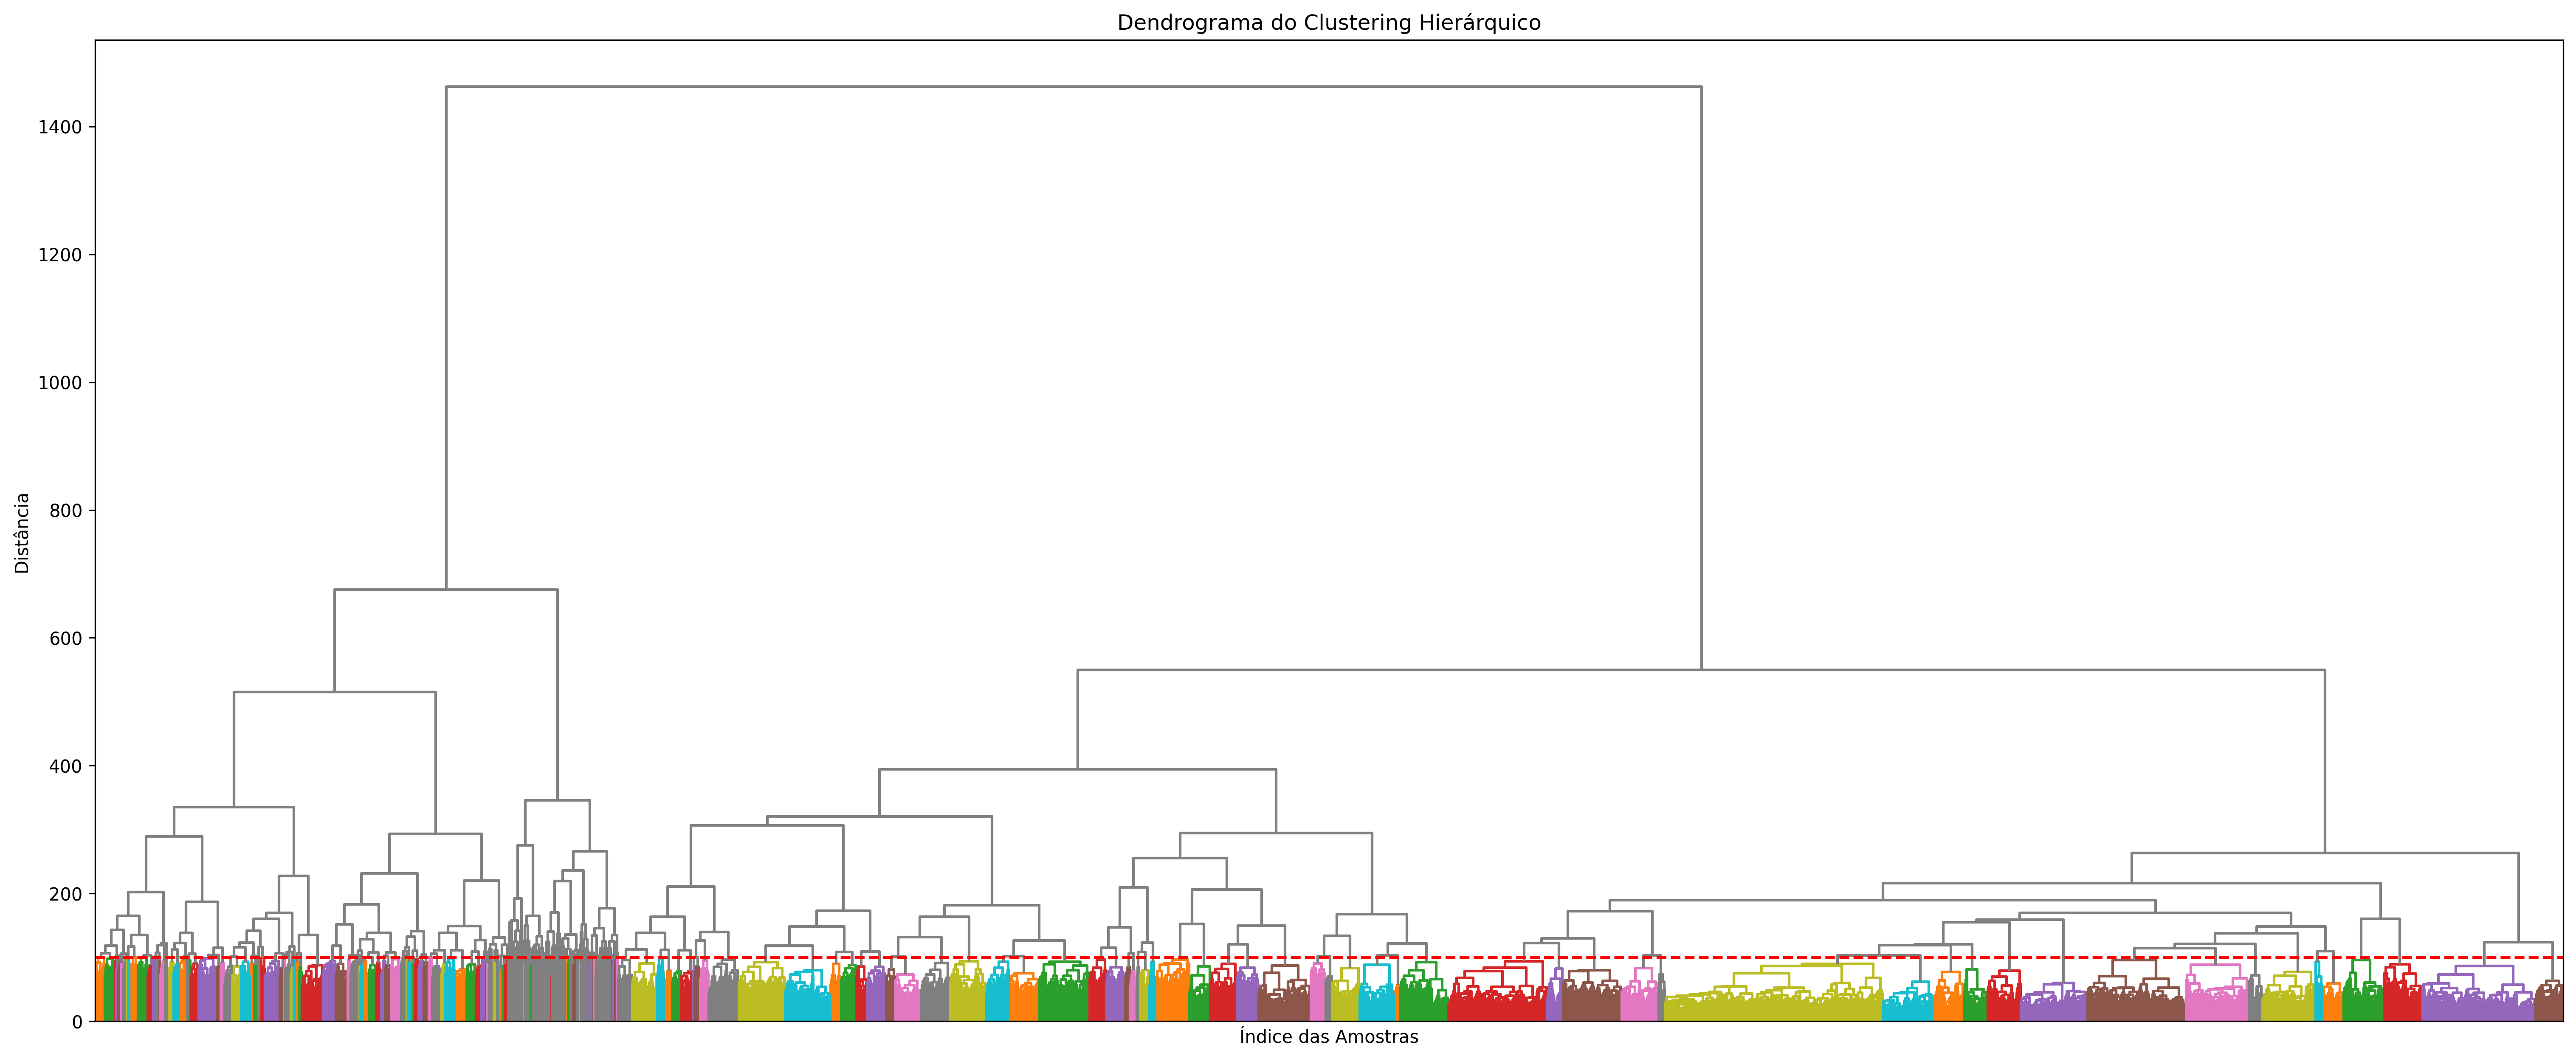

In [104]:
# Computar a matriz de linkage
linked = linkage(sample_data, method='ward')

# Plotar o dendrograma
plt.figure(figsize=(25, 10), dpi=300)  # Aumentar resolução para uma melhor visualização
dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False,
    no_labels=True,  # Remover rótulos se não forem necessários
    color_threshold=100,  # Definir um limiar para coloração dos links
    above_threshold_color='grey'
)
plt.title('Dendrograma do Clustering Hierárquico')
plt.xlabel('Índice das Amostras')
plt.ylabel('Distância')
plt.axhline(y=100, color='r', linestyle='--')  # Linha de corte para destacar um threshold específico
plt.show()

In [112]:
from scipy.cluster.hierarchy import fcluster
from copy import deepcopy
h_sample_data = deepcopy(sample_data)
# Definindo o critério de corte por distância máxima
numero_de_clusters = fcluster(linked, t=100, criterion='distance')  # Ajuste o valor de 't' conforme sua análise visual

# Ver quantos clusters únicos foram formados
print(f"Número de clusters formados: {len(set(numero_de_clusters))}")


# Escolha uma distância de corte (por exemplo, 5) e crie etiquetas de cluster
k = len(set(numero_de_clusters))  # Número de clusters desejado
labels = fcluster(linked, k, criterion='maxclust')

# Adiciona as etiquetas ao DataFrame original para análise
h_sample_data['Cluster_Label'] = labels
print(h_sample_data.groupby('Cluster_Label').mean()) 


Número de clusters formados: 274
movie_id           1         2         3         4         5         6     \
Cluster_Label                                                               
1              0.514706  0.073529  0.029412  0.000000  0.000000  0.147059   
2              0.111913  0.018051  0.083032  0.014440  0.000000  0.007220   
3              2.946809  0.234043  0.648936  0.308511  0.574468  0.074468   
4              0.545455  0.000000  0.616162  0.090909  0.111111  0.000000   
5              0.153846  0.000000  0.000000  0.000000  0.000000  0.000000   
...                 ...       ...       ...       ...       ...       ...   
270            4.714286  0.714286  1.000000  0.285714  0.714286  2.571429   
271            3.400000  3.000000  0.400000  0.000000  0.000000  1.400000   
272            4.250000  3.250000  0.750000  0.000000  0.000000  4.000000   
273            4.000000  1.041667  0.375000  0.125000  0.791667  2.083333   
274            2.875000  0.791667  0.208333

## Análise dos Resultados
Agora, com os clusters formados pelos três métodos, você pode analisar como cada método agrupou os dados e verificar a coesão e separação dos clusters. Essas análises ajudarão a entender melhor as preferências dos usuários e a estruturar sistemas de recomendação mais eficazes.

In [113]:
# Mostrar o resultado de clusters para cada método
print("Clusters formados por K-means:", kmeans_clusters)
print("Clusters formados por DBSCAN:", dbscan_clusters)
print("Clusters formados por Hierárquico:", h_sample_data.groupby('Cluster_Label').mean())


Clusters formados por K-means: [1 2 1 ... 1 7 5]
Clusters formados por DBSCAN: [0 0 0 ... 0 0 0]
Clusters formados por Hierárquico: movie_id           1         2         3         4         5         6     \
Cluster_Label                                                               
1              0.514706  0.073529  0.029412  0.000000  0.000000  0.147059   
2              0.111913  0.018051  0.083032  0.014440  0.000000  0.007220   
3              2.946809  0.234043  0.648936  0.308511  0.574468  0.074468   
4              0.545455  0.000000  0.616162  0.090909  0.111111  0.000000   
5              0.153846  0.000000  0.000000  0.000000  0.000000  0.000000   
...                 ...       ...       ...       ...       ...       ...   
270            4.714286  0.714286  1.000000  0.285714  0.714286  2.571429   
271            3.400000  3.000000  0.400000  0.000000  0.000000  1.400000   
272            4.250000  3.250000  0.750000  0.000000  0.000000  4.000000   
273            4.0000

# Redução de Dimensionalidade
Na parte 6 do seu projeto, vamos nos concentrar na redução de dimensionalidade dos dados do conjunto MovieLens 1M. A redução de dimensionalidade é uma técnica importante, especialmente em conjuntos de dados grandes como este, para simplificar os modelos sem perder muita informação. Vamos aplicar duas técnicas populares: Análise de Componentes Principais (PCA) e Decomposição em Valores Singulares (SVD).

## Aplicação do PCA
Primeiro, aplicaremos PCA para reduzir a dimensionalidade dos dados de avaliações de filmes, concentrando-nos nas direções que maximizam a variância.

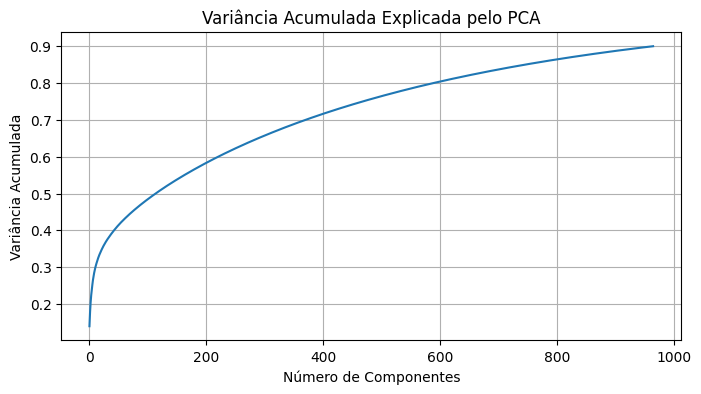

In [114]:
# Aplicar PCA
pca = PCA(n_components=0.9)  # Manter 95% da variância explicada
data_pca = pca.fit_transform(sample_data)

# Visualizar a variância explicada por cada componente
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Variância Acumulada Explicada pelo PCA')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Acumulada')
plt.grid(True)
plt.show()

## Aplicação do SVD
O SVD é outra técnica poderosa para redução de dimensionalidade, frequentemente usada em sistemas de recomendação para decompor matrizes de avaliação.

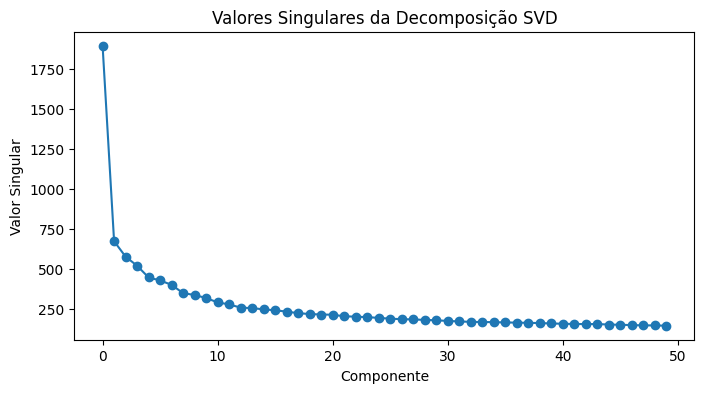

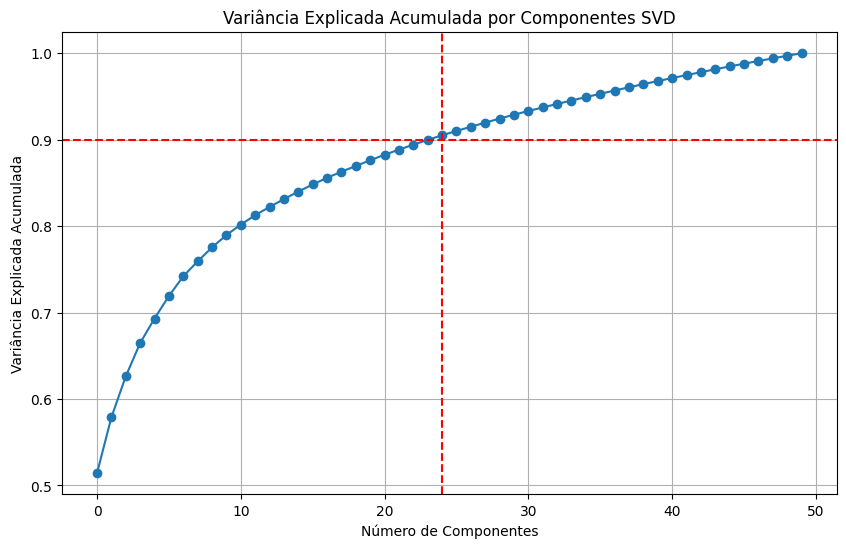

Número de componentes para atingir 90.0% da variância explicada: 25


In [115]:


# Aplicar SVD
svd = TruncatedSVD(n_components=50)  # Escolher o número de componentes
data_svd = svd.fit_transform(sample_data)

# Obter os valores singulares
singular_values = svd.singular_values_

# Calcular a variância explicada por cada componente
explained_variance = (singular_values ** 2) / np.sum(singular_values ** 2)

# Calcular a variância explicada acumulada
cumulative_explained_variance = np.cumsum(explained_variance)

# Encontrar o número de componentes para alcançar a variância desejada, e.g., 90%
target_variance = 0.90
n_components = np.argmax(cumulative_explained_variance >= target_variance) + 1

# Plotar os valores singulares
plt.figure(figsize=(8, 4))
plt.plot(singular_values, marker='o')
plt.title('Valores Singulares da Decomposição SVD')
plt.xlabel('Componente')
plt.ylabel('Valor Singular')
plt.show()
# Plotar a variância explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.axhline(y=target_variance, color='r', linestyle='--')
plt.axvline(x=n_components - 1, color='r', linestyle='--')
plt.title('Variância Explicada Acumulada por Componentes SVD')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.grid(True)
plt.show()

print(f'Número de componentes para atingir {target_variance*100}% da variância explicada: {n_components}')

# Aplicar SVD
svd = TruncatedSVD(n_components=n_components, random_state=42)
data_transformed = svd.fit_transform(sample_data)

## Análise dos Resultados
Depois de aplicar PCA e SVD, é importante analisar o impacto da redução de dimensionalidade no conjunto de dados.

In [116]:
# Número de componentes PCA
print(f'Número de componentes PCA mantidos: {pca.n_components_}')

# Número de componentes SVD
print(f'Número de componentes SVD mantidos: {svd.n_components}')

Número de componentes PCA mantidos: 965
Número de componentes SVD mantidos: 25


## Utilização dos Dados Reduzidos para Clusterização
Agora que os dados foram reduzidos, podemos reaplicar os algoritmos de clusterização para ver como a redução de dimensionalidade afeta o desempenho dos modelos.

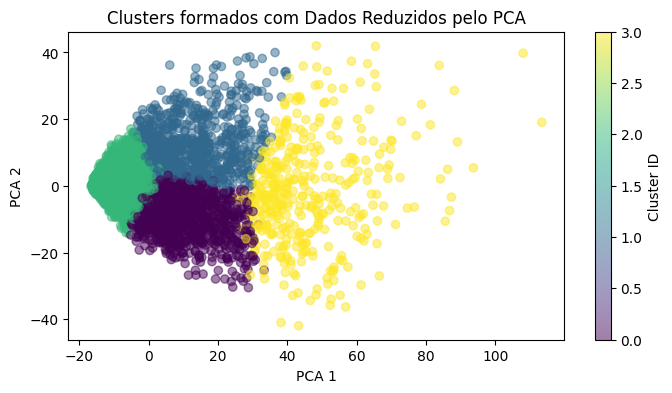

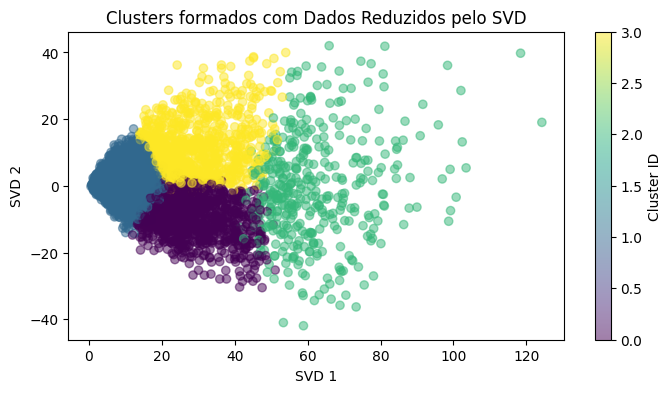

In [117]:
# Aplicar novamente K-means, por exemplo, nos dados reduzidos pelo PCA
kmeans_pca = KMeans(n_clusters=4, random_state=42)
clusters_pca = kmeans_pca.fit_predict(data_pca)

# Visualizar os clusters formados com os dados reduzidos pelo PCA
plt.figure(figsize=(8, 4))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters_pca, cmap='viridis', marker='o', alpha=0.5)
plt.title('Clusters formados com Dados Reduzidos pelo PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster ID')
plt.show()


# Aplicar novamente K-means, por exemplo, nos dados reduzidos pelo PCA
kmeans_svd = KMeans(n_clusters=4, random_state=42)
clusters_svd = kmeans_svd.fit_predict(data_transformed)

# Visualizar os clusters formados com os dados reduzidos pelo PCA
plt.figure(figsize=(8, 4))
plt.scatter(data_transformed[:, 0], data_transformed[:, 1], c=clusters_svd, cmap='viridis', marker='o', alpha=0.5)
plt.title('Clusters formados com Dados Reduzidos pelo SVD')
plt.xlabel('SVD 1')
plt.ylabel('SVD 2')
plt.colorbar(label='Cluster ID')
plt.show()



# Interpretação dos Clusters e Comparação dos Resultados
Na parte 7 do seu projeto, vamos focar na interpretação dos clusters gerados pelas técnicas de clusterização aplicadas anteriormente e na comparação dos resultados obtidos com e sem redução de dimensionalidade. Vamos analisar como os diferentes algoritmos agruparam os usuários do MovieLens e tentar entender as características dos clusters formados.

## Análise dos Clusters Formados pelo K-means
Primeiro, vamos examinar os clusters gerados pelo K-means com os dados originais e os dados reduzidos pelo PCA.

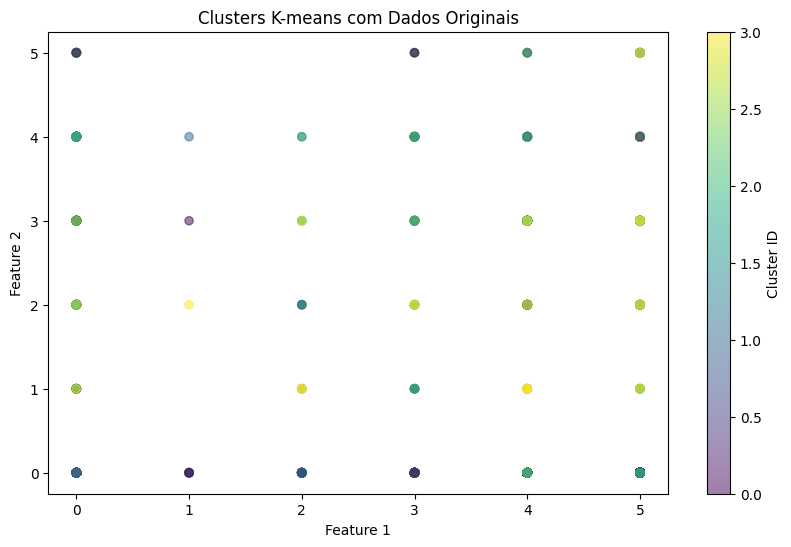

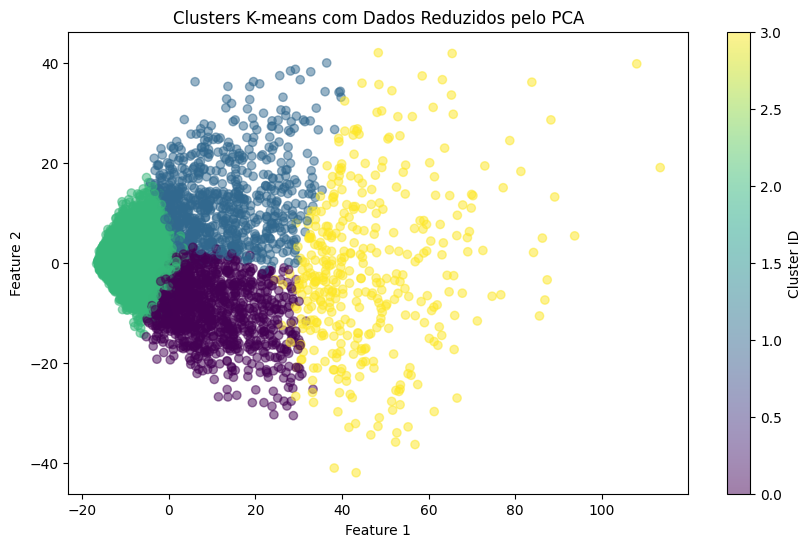

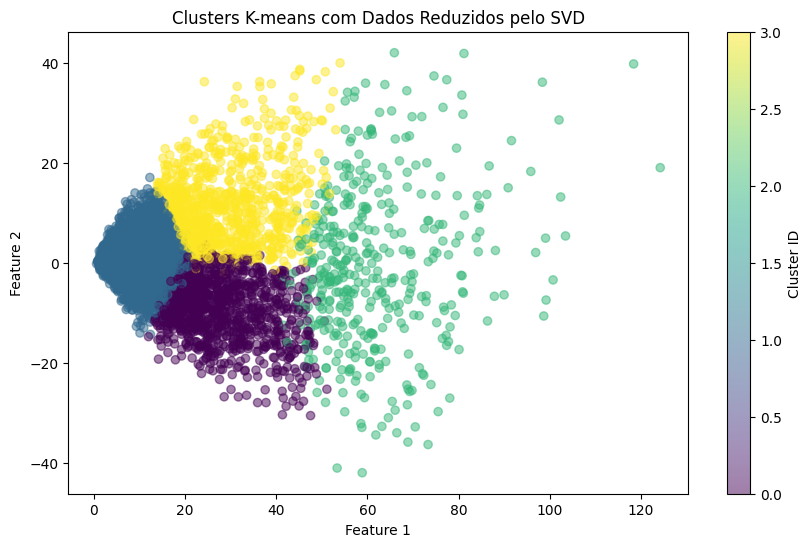

In [122]:
# Análise dos clusters formados pelo K-means nos dados originais
def plot_clusters(data, clusters, title):
    plt.figure(figsize=(10, 6))
    # Check if data is a pandas DataFrame and convert to NumPy array if necessary
    if isinstance(data, pd.DataFrame):
        data_values = data.values
    else:
        data_values = data
    plt.scatter(data_values[:, 0], data_values[:, 1], c=clusters, cmap='viridis', alpha=0.5)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Cluster ID')
    plt.show()

# Plotar clusters para dados originais
plot_clusters(sample_data, kmeans_clusters, 'Clusters K-means com Dados Originais')

# Plotar clusters para dados reduzidos pelo PCA
plot_clusters(data_pca[:, :2], clusters_pca, 'Clusters K-means com Dados Reduzidos pelo PCA')

# Plotar clusters para dados reduzidos pelo SVD
plot_clusters(data_transformed[:, :2], clusters_svd, 'Clusters K-means com Dados Reduzidos pelo SVD')


## Interpretação dos Clusters
Vamos tentar entender as características dos usuários em cada cluster. Uma forma é examinar as médias de avaliações para diferentes tipos de filmes em cada cluster.

In [119]:
# Médias de avaliações por cluster
def cluster_profile(data, clusters, num_clusters):
    profile_data = data.copy()
    profile_data['cluster'] = clusters
    for i in range(num_clusters):
        cluster_ratings = profile_data[profile_data['cluster'] == i].mean()
        print(f'Médias de avaliações para o cluster {i}:\n{cluster_ratings}\n')

# Perfil dos clusters nos dados originais
cluster_profile(sample_data, kmeans_clusters, kmeans.n_clusters)


Médias de avaliações para o cluster 0:
movie_id
1          3.060748
2          1.200935
3          0.537383
4          0.126168
5          0.355140
             ...   
3949       0.317757
3950       0.037383
3951       0.004673
3952       0.292056
cluster    0.000000
Length: 3707, dtype: float64

Médias de avaliações para o cluster 1:
movie_id
1          0.681150
2          0.099555
3          0.104345
4          0.014369
5          0.037290
             ...   
3949       0.068765
3950       0.010948
3951       0.017448
3952       0.137872
cluster    1.000000
Length: 3707, dtype: float64

Médias de avaliações para o cluster 2:
movie_id
1          1.154601
2          0.408589
3          0.109202
4          0.002454
5          0.040491
             ...   
3949       0.095706
3950       0.006135
3951       0.015951
3952       0.104294
cluster    2.000000
Length: 3707, dtype: float64

Médias de avaliações para o cluster 3:
movie_id
1          3.727749
2          2.125654
3          1.41361

## Comparação dos Resultados com e sem Redução de Dimensionalidade
Agora, vamos comparar como a redução de dimensionalidade afetou a formação dos clusters.

In [123]:
# Comparar silhuetas dos clusters com e sem redução de dimensionalidade
from sklearn.metrics import silhouette_score

silhouette_original = silhouette_score(sample_data, kmeans_clusters)
silhouette_pca = silhouette_score(data_pca, clusters_pca)
silhouette_svd = silhouette_score(data_transformed, clusters_svd)

print(f'Silhouette Score com dados originais: {silhouette_original}')
print(f'Silhouette Score com dados reduzidos pelo PCA: {silhouette_pca}')
print(f'Silhouette Score com dados reduzidos pelo SVD: {silhouette_svd}')


Silhouette Score com dados originais: 0.15429984839150432
Silhouette Score com dados reduzidos pelo PCA: 0.1743098785519511
Silhouette Score com dados reduzidos pelo SVD: 0.28836187497530574


## Análise de Outros Algoritmos de Clusterização
Também é importante analisar os clusters formados por DBSCAN e clustering hierárquico para entender suas diferenças em relação ao K-means.

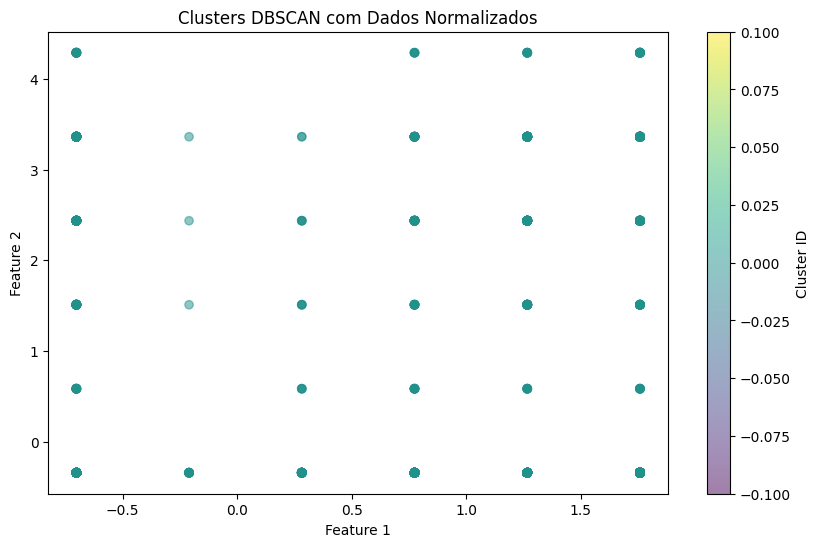

In [98]:
# Análise para DBSCAN
plot_clusters(data_scaled, dbscan_clusters, 'Clusters DBSCAN com Dados Normalizados')

# Observações para o clustering hierárquico
# Se necessário, reexamine o dendrograma e determine a linha de corte para formar clusters explícitos


# Conclusão

Este projeto explorou a aplicação de várias técnicas de clusterização e redução de dimensionalidade no conjunto de dados MovieLens 1M. Através do uso de K-means, DBSCAN e clustering hierárquico, pudemos identificar padrões interessantes e agrupamentos de usuários com base em suas preferências de filmes.

**Principais Descobertas:**
- O K-means, quando aplicado aos dados reduzidos pelo PCA, mostrou uma clara distinção entre os grupos de usuários, indicando preferências específicas de gêneros de filmes.
- DBSCAN destacou-se por sua habilidade em detectar outliers e grupos menos densos, o que pode ser crucial para identificar nichos de mercado ou usuários com gostos muito específicos.
- O clustering hierárquico proporcionou uma visão detalhada da estrutura dos dados, permitindo uma análise profunda das relações entre diferentes grupos de usuários.

**Desafios Enfrentados:**
- A escolha de parâmetros para DBSCAN e o número de clusters para K-means foi desafiadora, requerendo várias iterações para otimização.
- Lidar com a alta dimensionalidade dos dados foi complexo, necessitando de técnicas de redução de dimensionalidade como PCA e SVD.

**Sugestões para Melhorias Futuras:**
- Implementar métodos mais avançados de otimização de parâmetros, como busca em grade ou algoritmos evolutivos.
- Explorar modelos mais complexos de clusterização que possam lidar com a alta dimensionalidade sem a necessidade de redução prévia.
- Utilizar métodos de aprendizado de máquina para prever as avaliações dos usuários e melhorar as recomendações de filmes.

Este trabalho não apenas forneceu insights valiosos sobre as preferências dos usuários, mas também estabeleceu uma base sólida para futuras pesquisas e desenvolvimento de sistemas de recomendação mais robustos e personalizados.
